In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import networkx as nx
from math import radians, cos, sin, asin, sqrt
use_cols = ['ROUTE_NAME','F_STTN_ID','F_STTN_ISC_ID','T_STTN_ID','T_STTN_ISC_ID','TRANSIT_TIME','STOP_SEQ']

In [2]:
"""위경도 거리계산 함수"""
"""
신규,변경 노선의 경우, 경유 정류장 간 bms데이터가 없는 경우가 생길 수 있음
따라서 정류장간 거리를 구한 후, 시내버스 평균속도(현재 15로 산정)를 나누어 정류장간 통행시간을 산출 
"""
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [3]:
"""정류장 정보 dataframe"""
stn_status = pd.read_excel('20200806_V12_경유정류장순서_서민호(200810.v1.김민기).xlsx',
                           sheet_name='정류장위치',dtype=str)
stn_status.head()

,Sttn Id,Sttn Isc Id,Sttn Name,Sttn Lat,Sttn Lon
0,232000077,2800001,양도마을.대림아파트,37.604731898,126.722346797
1,232000076,2800002,양도마을.대림아파트,37.604322917,126.722033457
2,232000075,2800003,수행마을,37.607893558,126.723575258
3,232000074,2800004,수행마을,37.607893308,126.723216093
4,232000073,2800005,유현마을.신동아아파트,37.59642183,126.721286176


In [4]:
stn_status2 = pd.read_excel('excel_station_status.xlsx',dtype=str,
                           usecols=['정류소 명','정류소 ID','ISC 정류소 ID','위도','경도'])
stn_status2.head()

,정류소 명,정류소 ID,ISC 정류소 ID,위도,경도
0,(구)시민회관사거리,163000319,2802757,126.68018830433286,37.457360395358165
1,(구)시민회관사거리,163000326,2802755,126.67992703811578,37.45776642315442
2,(구)신현주공,168000228,2800619,126.67339452968905,37.52184277702059
3,(구)현대백화점,166000158,2801688,126.71126751729724,37.490948333960574
4,(주)경동세라믹스,168001146,2806735,126.61697759175779,37.559185515339


In [5]:
"""정류장 정보 검색 함수"""
def find_stn_status(id_):
    """
    id를 넣으면 [정류장명, 위도, 경도] 값을 return
    """
    try:
        if len(id_)==7:
            return stn_status[stn_status['Sttn Isc Id']==id_][['Sttn Name','Sttn Lon','Sttn Lat']].values[0]
        return stn_status[stn_status['Sttn Id']==id_][['Sttn Name','Sttn Lon','Sttn Lat']].values[0]
    except IndexError:
        if len(id_)==7:
            return stn_status2[stn_status2['ISC 정류소 ID']==id_][['정류소 명','위도','경도']].values[0]
        return stn_status2[stn_status2['정류소 ID']==id_][['정류소 명','위도','경도']].values[0]

In [6]:
"""bms data load 및 negative, zero value 제거"""
bms_data = pd.read_csv('BMSdata_20200731_윤남식V2.csv',dtype=str,usecols=use_cols)
negative_idx = bms_data[bms_data['TRANSIT_TIME'].astype(float)<=0].index
bms_data.drop(negative_idx,inplace=True)
bms_data.head()

,ROUTE_NAME,F_STTN_ID,F_STTN_ISC_ID,T_STTN_ID,T_STTN_ISC_ID,STOP_SEQ,TRANSIT_TIME
0,12,168000066,2800760,168000085,2800741,34,32.0
1,12,168000085,2800741,168000101,2800725,35,40.0
2,12,168000101,2800725,168000136,2800691,36,186.0
3,12,168000136,2800691,168000143,2800684,37,48.0
4,12,168000143,2800684,168000151,2800676,38,119.0


In [7]:
"""존치된 노선들의 노선명과 시에서 인가한 운행시간"""
existed_routes_df = pd.read_excel('존치노선.xlsx',dtype=str)
existed_routes_df.head()

,노선번호,운행시간
0,117,105
1,10,216
2,103,276
3,111,275
4,112,265


In [8]:
"""  존치노선들의 노선명이 bms_data에 존재하는지 확인                   """
"""  bms_data에 들어있는 nan 노선명이 598-1이 아닐까 추측하였으나,       """
"""  아니고 7,43,72번 중 하나의 노선임(bms애 3개 노선전부 찍히긴함)      """
"""  -----------------------------------------------------------    """
bms_route_name = bms_data['ROUTE_NAME'].unique()
for route_name in existed_routes_df['노선번호']:
    if route_name not in bms_route_name:
        print('bms에 찍히지않은 노선 : ',route_name)

bms에 찍히지않은 노선 :  598-1


# 117번노선을 예시로 bms_data_df로 노선추출 

```

issue 1) 정해진 노선대로 다니지않고, 임의의 정류장이 to_station에 찍힘 
ex) 노선도가 a-b-c-d 일때, (a,b) 및 (a,c)가 존재
sol fail) F-T를 tree 구조로 변환하여 max_depth를 구하여 노선도를 복원 -> cyclic 구조로인해 불가 
위 예시 a-b-c-d 중 (d,a)가 존재
sol clear) bms_data에서 STOP_SEQ 순서대로 출발 정류장ID를 나열

==================================================================
==================================================================

issue 2) i번째 to stn이 i+1번째 from stn이 되지않는경우가 존재(버스가 정차하지않고 지나간것으로 추정)

ex) 117번 노선의 stop_seq의 내림차순한 결과 ***가 해당
LH7단지 - 센트럴푸르지오자이 - 한양수자인(옆문) - 우미린2단지 정문 - ... - 우미린1단지후문 - 영종KCC스위첸옆문 - 인천공항TG(미정차) - 개화역 - 인천공항TG(미정차) - 영종KCC스위첸옆문 - 우미린1단지후문 (네이버맵 기준)

['T id'      'T isc id''F id'      'F isc id']
['161000452' '2805694' '161000660' '2805636'] *** (LH7단지, 센트럴푸르지오자이)
['161000510' '2806053' '161000513' '2806032']     (한양수자인(옆문),우미린2단지정문) 
['161000513' '2806032' '161000455' '2806025']
['161000455' '2806025' '161000488' '2805697']
['161000488' '2805697' '161000457' '2805699']
['161000457' '2805699' '161000459' '2805701']
['161000459' '2805701' '161000651' '2807440']
['161000651' '2807440' '161000583' '2806806']
['161000583' '2806806' '161000462' '2805704']     (우미린1단지정문, 우미린1단지후문)
['161000462' '2805704' '161000756' '2807625'] *** (우미린1단지후문, 영종KCC스위첸옆문)
['168000690' '2807549' '168000691' '2807548'] *** (인천공항TG(미정차), 인천공항TG(미정차))
['115000182' '2806228' '168000691' '2807548'] *** (개화역, 인천공항TG(미정차))
['168000691' '2807548' '161000755' '2807626'] *** (인천공항TG(미정차), 영종KCC스위첸옆문)
['161000461' '2805703' '161000584' '2806807']     (우미린1단지후문, 우미린1단지정문)
['161000584' '2806807' '161000650' '2807439']
['161000650' '2807439' '161000460' '2805702']
['161000460' '2805702' '161000458' '2805700']
['161000458' '2805700' '161000489' '2805698']
['161000489' '2805698' '161000456' '2806024']
['161000456' '2806024' '161000512' '2806031']
['161000512' '2806031' '161000537' '2806083']
['161000537' '2806083' '161000661' '2805637']     (한양수자인(옆문),센트럴푸르지오자이)

sol fail) i+1번째 row 삭제? -> 네이버맵 기준으로 노선도를 볼때 삭제하면 안됨
sol clear) i번째 row의 to를 from으로, i+1번째 row의 from을 to로 하는 row를 삽입

```

In [9]:
"""  bms_data에서 117노선의 정보만 추출      """
"""  -----------------------------------   """
bms_data_df_117 = bms_data[bms_data['ROUTE_NAME']=='117']
bms_data_df_117.head()

,ROUTE_NAME,F_STTN_ID,F_STTN_ISC_ID,T_STTN_ID,T_STTN_ISC_ID,STOP_SEQ,TRANSIT_TIME
1626690,117,168000690,2807549,168000691,2807548,11,1687.0
1626691,117,168000691,2807548,161000755,2807626,13,844.0
1626692,117,161000461,2805703,161000584,2806807,14,50.0
1626693,117,161000584,2806807,161000650,2807439,15,13.0
1626694,117,161000650,2807439,161000460,2805702,16,17.0


In [10]:
"""  추출된 df에서 unique_stop_seq 추출    """
"""  ----------------------------------- """
unique_stop_seq = sorted([int(i) for i in bms_data_df_117['STOP_SEQ'].unique()])
unique_stop_seq

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [11]:
"""  issue2 해결을 위한 방법                   """
"""  직전 i-1 row의 to stn을 기억한 후,         """
"""  직전 i row의 from stn과 다를 경우,          """
"""  직전 i-1 to stn, i from stn을 seq에 삽입   """
"""  ---------------------------------------- """
i_1_value = bms_data_df_117[bms_data_df_117['STOP_SEQ']==str(unique_stop_seq[0])].values[0,1:5]
i_1_from_stn, i_1_to_stn = i_1_value[0], i_1_value[2]
seq_117 = [i_1_from_stn]

for i in unique_stop_seq[1:]:
    value = bms_data_df_117[bms_data_df_117['STOP_SEQ']==str(i)].values[0,1:5]
    i_from_stn, i_to_stn = value[0],value[2]
    if i_1_to_stn == i_from_stn:
        seq_117.append(i_from_stn)
        i_1_from_stn, i_1_to_stn = i_from_stn, i_to_stn
    else:
        seq_117+=[i_1_to_stn,i_from_stn]
        i_1_from_stn, i_1_to_stn = i_from_stn, i_to_stn
        
"""
아래 시간맵 산출의 세부 issue 2에 의해 추가
(중복되는 노선이 존재하여 제거)
"""
temp_copy = seq_117.copy()
for i,stn1 in enumerate(temp_copy):
    for stn2 in temp_copy[i+1:]:
        if stn1==stn2:
            seq_117.remove(stn2)
    

In [12]:
"""BMS DATA에 의해 복원된 117번 노선"""
seq_117

['161000452',
 '161000660',
 '161000510',
 '161000513',
 '161000455',
 '161000488',
 '161000457',
 '161000459',
 '161000651',
 '161000583',
 '161000462',
 '161000756',
 '168000690',
 '115000182',
 '168000691',
 '161000755',
 '161000461',
 '161000584',
 '161000650',
 '161000460',
 '161000458',
 '161000489',
 '161000456',
 '161000512',
 '161000537']

# 존치노선(598-1 제외)들의 노선도 산출

In [13]:
existed_routes_name = existed_routes_df['노선번호'].tolist()
existed_routes_seq = {}
for route_name in tqdm(existed_routes_name):
    if route_name == '598-1':continue
        
    bms_data_temp_df = bms_data[bms_data['ROUTE_NAME']==route_name]
    unique_stop_seq = sorted([int(i) for i in bms_data_temp_df['STOP_SEQ'].unique()])
    
    i_1_value = bms_data_temp_df[bms_data_temp_df['STOP_SEQ']==str(unique_stop_seq[0])].values[0,1:5]
    i_1_from_stn, i_1_to_stn = i_1_value[0], i_1_value[2]
    seq = [i_1_from_stn]

    for i in unique_stop_seq[1:]:
        value = bms_data_temp_df[bms_data_temp_df['STOP_SEQ']==str(i)].values[0,1:5]
        i_from_stn, i_to_stn = value[0],value[2]
        if i_1_to_stn == i_from_stn:
            seq.append(i_from_stn)
            i_1_from_stn, i_1_to_stn = i_from_stn, i_to_stn
        else:
            seq+=[i_1_to_stn,i_from_stn]
            i_1_from_stn, i_1_to_stn = i_from_stn, i_to_stn
    temp_copy = seq.copy()
    for i,stn1 in enumerate(temp_copy):
        for stn2 in temp_copy[i+1:]:
            if stn1==stn2:
                seq.remove(stn2)
    existed_routes_seq[route_name] = seq

100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [00:43<00:00,  1.87it/s]


# 117번노선을 예시로 노선시간 산정

```

issue 1) 117번의 노선도는 아래와 같은데, *** stn을 i라 할때, (i,i+1) 운행기록이 없음
 
['161000452',     LH7단지
 '161000660', *** 센트럴푸르지오자이
 '161000510',     한양수자인(옆문)
 '161000513',
 '161000455',
 '161000488',
 '161000457',
 '161000459',
 '161000651',
 '161000583',
 '161000462',     우미린1단지후문
 '161000756', *** 영종KCC스위첸옆문
 '168000690',     인천공항TG(미정차)
 '168000691', *** 인천공항TG(미정차) <- 얘가 이상함(정류장이 중복되며, TG를 두번지나는게..)
 '115000182',     개화역(회차)
 '168000691',     인천공항TG(미정차)
 '161000755', *** 영종KCC스위첸옆문
 '161000461',     우미린1단지후문
 '161000584',
 '161000650',
 '161000460',
 '161000458',
 '161000489',
 '161000456',
 '161000512',
 '161000537']
 
 세부 issue 1) LH7단지에서 센트럴푸르지오자이로 갔던 운행기록은 존재하나, 센트럴푸르지오자이에서 한양수자인(옆문)으로 갔던 운행기록이 존재하지 않음 
 세부 issue 2) 위 리스트 중 '<-' 표시된 정류소로 인해 노선도가 기형적으로 변하며, 시간맵을 산정할 시, 문제가 됨
 
 sol 1) 운행기록이 없는것은 어쩔수없다고 판단, 시간맵 산정시 pass
 sol 2) 해당 경우는 회차지 근방(개화역)에서 승하차기록이 없는경우로 사료되며, 톨게이트에서 바로 다시 톨게이트로 오는 경우임. 따라서, 첫번째 168000691은 노선도에서 삭제를 해야함. <- how?) iteration을 i stn이 i+n stn과 중복된다면, i를 제거
 
 바뀐 정류장 시퀀스
 
 ['161000452',     LH7단지
 '161000660', *** 센트럴푸르지오자이
 '161000510',     한양수자인(옆문)
    ...
 '161000462',     우미린1단지후문
 '161000756', *** 영종KCC스위첸옆문
 '168000690',     인천공항TG(미정차)
 '115000182',     개화역(회차)
 '168000691',     인천공항TG(미정차)
 '161000755', *** 영종KCC스위첸옆문
 '161000461',     우미린1단지후문
     ...
 '161000537']
 
 ==================================================================
 ==================================================================

 issue 2) TG를 전후로하여 운행기록이 존재하지않음. 실제 정류소로보면 영종KCC스위첸옆문-개화역-영종KCC스위첸옆문이 오고가는 정류소임. TG를 지나는 비슷한 노선 308의 노선을 볼때는 다음과같으며, 117번과 달리 예쁘게 \\잘들어있음//
 
 ['232000080',     북변환승센터.구터미널(기점)
     ...
 '168000299',     서부공단입구
 '168001287',     북인천하부TG(미정차)
 '161000634',     금산IC(미정차)
 '161000203',     인천공항T1(3층7번)
 '161000556',
 '161000615',     인천공항T2(8)번출입구(3층) 회차
     ...
 '161000026',     국제업무단지(공항청사)
 '161000635',     금산IC(미정차)
 '168000901',     북인천하부TG(미정차)
 '168001034',     청라국제도시역
    ...
 '232000064']     풍년마을.김포고(걸포사거리방면)
 
 sol) 기존노선의 시간맵 산정시, 문제 되지않을것으로 보이기 때문에 pass
 (실제로 117노선의 운행기록중 TG에서 개화역 운행기록의 약 20분은 영종하늘도시KCC스위첸에서 개화역과 동일)
```

In [14]:
"""  빠른 속도를 위해 dataframe이 아닌 array형식으로 time값 검색"""
"""  ------------------------------------------------------ """
bms_data_array = bms_data.values
bms_data_array

array([['12', '168000066', '2800760', ..., '2800741', '34', '32.0'],
       ['12', '168000085', '2800741', ..., '2800725', '35', '40.0'],
       ['12', '168000101', '2800725', ..., '2800691', '36', '186.0'],
       ...,
       ['540', '165000462', '2801941', ..., '2801944', '2', '53.0'],
       ['538', '165000443', '2801958', ..., '2801947', '5', '29.0'],
       ['538', '165000455', '2801947', ..., '2801939', '6', '30.0']],
      dtype=object)

In [15]:
"""  117노선이 161000452(LH7단지)와                 """
"""  161000660(센트럴푸르지오자이)을 다닌 시간들을 산출 """
"""  ----------------------------------------------"""
_117_array = bms_data_array[bms_data_array[:,0]=='117']
stn1_array = _117_array[_117_array[:,1]=='161000452']
stn1stn2_array = stn1_array[stn1_array[:,3]=='161000660']

time_array = stn1stn2_array[:,-1].astype(float)
time_array.mean()

65.28947368421052

In [16]:
"""  117노선의 노선도를 통해 산출    """
"""  ---------------------------- """
t_117 = 0
_117_array = bms_data_array[bms_data_array[:,0]=='117']
for stn1,stn2 in zip(existed_routes_seq['117'][:-1],existed_routes_seq['117'][1:]):
    stn1_array = _117_array[_117_array[:,1]==stn1]
    stn1stn2_array = stn1_array[stn1_array[:,3]==stn2]
    
    time_array = stn1stn2_array[:,-1].astype(float)
    if len(time_array)==0:continue
    time_avg = time_array.mean()
    t_117+=time_avg/60
t_117 ## 위의 65.289는 초이고, 아래 65.649는 분입니다

65.64936897971688

# 존치노선 운행시간 산정

```
issue 1) 특정 노선의 타임이 너무큼
ex)
12번 산출값 = 737.88, 인가시간 = 294
 2번 산출값 = 713.17, 인가시간 = 237
 
sol) 
구간 평균 운행시간이 10분이상이며, 해당 구간의 직선거리를 통한 평균속도가 5km/h 미만인 구간은 제외
평균속도가 5km/h 미만인 구간은 휴식을 취한 구간이라고 판단
```

In [17]:
quantile_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

result = pd.DataFrame(index = existed_routes_name, columns=quantile_values)
for quantile_value in quantile_values:    
    existed_routes_time = {}
    bms_data_array = bms_data.values
    for route_name in existed_routes_name:
        if route_name=='598-1':continue
        t = 0
        _array = bms_data_array[bms_data_array[:,0]==route_name] ## route_name에 해당된 모든 기록 array
        for stn1,stn2 in zip(existed_routes_seq[route_name][:-1],existed_routes_seq[route_name][1:]):
            stn1_array = _array[_array[:,1]==stn1]
            stn1stn2_array = stn1_array[stn1_array[:,3]==stn2]
            time_array = stn1stn2_array[:,-1].astype(float) ## route_name 이 stn1과 stn2를 운행한 기록 array
            if len(time_array)==0:continue
            ## 117번과 같은 경우, time_array가 빈 리스트일수 있으나, 무시하면됨

            #######################################
            ############                 ##########
            ############  상위 하위 조절  ##########
            ############                 ##########
            #######################################

            quantile = np.quantile(time_array, quantile_value, interpolation='nearest')
            time_array = time_array[time_array>=quantile]

            time_avg = time_array.mean()/60

            #######################################
            ############                 ##########
            ############     issue 1     ##########
            ############                 ##########
            #######################################
            if time_avg>10:
                stn1_name,stn1_lat,stn1_lon = find_stn_status(stn1)
                stn2_name,stn2_lat,stn2_lon = find_stn_status(stn2)
                dist = haversine(float(stn1_lat),float(stn1_lon),float(stn2_lat),float(stn2_lon))
                if dist/(time_avg/60) < 5:
                    ## 버스 뒤에서 밀어서 운행하는 속도수준은 제외(maybe 휴식시간)
                    continue
            t+=time_avg
        existed_routes_time[route_name] = t
    for route_name in existed_routes_time:
        result.loc[route_name,quantile_value] = existed_routes_time[route_name]

In [18]:
result

,0.0,0.1,0.2,0.3,0.4,0.5
117,65.6494,67.6872,69.9731,72.1295,74.5348,76.4947
10,161.236,169.59,177.871,186.654,196.401,206.485
103,232.082,245.299,259.217,274.525,291.239,309.556
111,169.188,176.763,184.917,193.347,202.167,212.395
112,225.325,237.544,250.2,263.527,277.078,292.237
...,...,...,...,...,...,...
800,257.149,267.727,277.767,288.172,299.18,311.898
905,194.403,204.943,205.255,215.554,226.788,239.01
908,119.565,125.196,130.486,136.13,142.126,148.697
909,146.361,153.588,160.701,168.072,175.739,183.908


In [19]:
# result.to_csv('존치노선_전수검사0814.csv',encoding='utf8')

# 변경,신설 노선을 위한 시간맵 작성
# 511번노선을 예시로 노선시간 산정
```
기존노선의 운행시간 산출에 사용된 방식을 적용하며, 적절한 정류장간 이격거리를 위해 정류장간 운행시간이 1분 미만인 운행기록은 삭제

511의 경로에 다닥다닥붙은게 존재하기에 선정

issue 1) 링크에 정류장을 할당하다보니 정류장이 다닥다닥 붙어있을 수있음

sol) 기존노선의 운행시간 산출에 사용된 방식을 적용하였기에, 정확하진않으나 근사값을 산출할수있음
how) route_seq = [1,2,3,4,5]라 가정할때, i번째 정류장과 연결된 가장 가까운 i+n의 seq의 time을 할당한 후, i+n 정류장 부터 반복
```

In [20]:
"""  time_array를 할당한 후, 위와같이, 거리 및 속도 조건을 걸경우,    """
"""  정상적인 데이터가 날아갈 위험이 있음                            """
"""  따라서 각 row마다 해당 조건을 걸어줌                            """
"""  time_map = {(stn1,stn2):[time_list],(stn1,stn2):[time_list]}"""
"""  ----------------------------------------------------------  """
## 시간 오래걸리니 조심
time_map = {}
bms_data_array = bms_data.values
for row in tqdm(bms_data_array):
    route_name, stn1_id, stn1_isc_id, stn2_id, stn2_isc_id, stop_seq, time = row
    time = float(time)/60
    
    if stn1_id==stn2_id:continue
    if time<1:continue
        
    stn1_name,stn1_lat,stn1_lon = find_stn_status(stn1_id)
    stn2_name,stn2_lat,stn2_lon = find_stn_status(stn2_id)
    
    dist = haversine(float(stn1_lat),float(stn1_lon),float(stn2_lat),float(stn2_lon))
    
    if dist/(float(time)/60) < 3:
        ## 버스 뒤에서 밀어서 운행하는 속도수준은 제외(maybe 휴식시간)
        continue
    try:
        time_map[(stn1_isc_id,stn2_isc_id)].append(float(time))
    except KeyError:
        time_map[(stn1_isc_id,stn2_isc_id)] = [float(time)]   


100%|█████████████████████████████████████████████████████████████████████| 6680193/6680193 [2:54:58<00:00, 636.29it/s]


In [21]:
stn2_id

'165000464'

In [22]:
kisti_routes_seq = pd.read_excel('20200806_V12_경유정류장순서_서민호(200810.v1.김민기).xlsx',
                                 sheet_name='노선, 정류장 정보',dtype=str)
kisti_routes_seq.head()

,노선 id,노선명,정류장명,정류장 ID,노선명 텍스트
0,28001001,9100,숭의역(1번출구),2802621,9100
1,28001001,9100,숭의로터리,2802809,9100
2,28001001,9100,제물포역,2802635,9100
3,28001001,9100,주안사거리,2802617,9100
4,28001001,9100,석바위,2802728,9100


In [23]:
seq_511 = kisti_routes_seq[kisti_routes_seq['노선명 텍스트']=='511']['정류장 ID'].tolist()
seq_511

['2807441',
 '2806808',
 '2806914',
 '2802920',
 '2807167',
 '2802898',
 '2802895',
 '2802894',
 '2802887',
 '2802862',
 '2802803',
 '2802774',
 '2802760',
 '2802617',
 '2802733',
 '2807110',
 '2802710',
 '2802734',
 '2802756',
 '2805155',
 '2802794',
 '2802852',
 '2802880',
 '2802890',
 '2802893',
 '2802896',
 '2805500',
 '2802934',
 '2806811',
 '2806809']

In [24]:
"""511노선 산정 시간"""
stn1 = seq_511[0]
t_511 = 0
while True:
    for stn2 in seq_511[seq_511.index(stn1)+1:]:
        try:
            time_array = np.array(time_map[(stn1,stn2)])
            quantile = np.quantile(time_array, 0.3, interpolation='nearest')
            time_array = time_array[time_array>=quantile]
            
            t_511+=time_array.mean()
            stn1 = stn2
            break
        except KeyError:
            continue
    if stn2==seq_511[-1]:break
t_511

59.456317999136175

# 전체노선 적용

```
issue 1) kisti노선에서 상행에서 이미한번 들린 정류소를 하행에서 들리는 경우가 있음

sol) 117번노선을 예시로 노선시간 산정의 세부 issue 2 와 같다고 판단하여 하행시 방문하는 중복된 정류소는 제거

issue 2) 모든 경로가 time_map에서 검색이 안되는경우가 있을수있음

sol) i번째 정류소에서부터 i+n 정류소 간의 time_map 기록이 없을 경우, (i,i+1)의 평균속력인 거리/15로 time을 계산한후, i+1정류소부터 다시 탐색

issue 3) 204_변경에서 정류장 sequence에 nan값이 들어있음
ex)
[nan,
 '2806541',
 '2806543',
 '2805676',
 '2805630',
 '2807038'...]
 
 sol) nan값이 들어있는지 체크하고 사전제거
 
 issue 4) 위도경도값이 0인 정류소들이 존재
 ex)무의지소
```
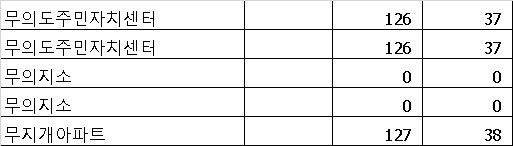

```
sol) time_map값 및 위경도 값도 없으니 pass

issue 5) 정류소현황목록에서 검색이 되지않는 정류소가 있음(also kisti data)

sol) pass
```

In [25]:
quantile_values = [0,0.1,0.2,0.3,0.4,0.5]

result = pd.DataFrame(index = kisti_routes_seq['노선명 텍스트'].unique(),columns=quantile_values)
for quantile_value in quantile_values:
    routes_time = {}
    for route_name in kisti_routes_seq['노선명 텍스트'].unique():
        seq = kisti_routes_seq[kisti_routes_seq['노선명 텍스트']==route_name]['정류장 ID'].tolist()
        
        """issue 3"""
        seq = [stn for stn in seq if type(stn)==str]
        ###################################################
        """issue 1"""
        temp_copy = seq.copy()
        for i,stn1 in enumerate(temp_copy):
            for stn2 in temp_copy[i+1:]:
                if stn1==stn2:
                    seq.remove(stn2)
        ####################################################
        
        stn1 = seq[0]
        t = 0
        while True:
            for stn2 in seq[seq.index(stn1)+1:seq.index(stn1)+4]:
                ## 뒤 몇개의 정류소까지 확인해볼꺼냐. 만약 길게한다면 점프뛰어버릴수도있음
                ## 링크당 최대 정류장갯수를 산정하여 넣는것도 방법일듯
                stack=0
                try:
                    time_array = np.array(time_map[(stn1,stn2)])
                    quantile = np.quantile(time_array, quantile_value, interpolation='nearest')
                    time_array = time_array[time_array>=quantile]
                    t+=time_array.mean()
                    stn1 = stn2
                    stack+=1
                    break
                except KeyError:
                    continue
            if stn1 == seq[-1]:break
            if stack==1:continue
            
            ##################################################################
            """issue 2"""
            stn2 = seq[seq.index(stn1)+1]
            ##################################
            """issue 4 및 5"""
            try:
                stn1_name,stn1_lat,stn1_lon = find_stn_status(stn1)
                stn2_name,stn2_lat,stn2_lon = find_stn_status(stn2)
            except IndexError:
                stn1=stn2
                continue
            if stn1_lat==0:## 무의지소 case
                stn1=stn2
                continue
            ###################################
            dist = haversine(float(stn1_lat),float(stn1_lon),float(stn2_lat),float(stn2_lon))
            t += ((dist*60*(1+quantile_value))/15)
            stn1=stn2
            if stn1 == seq[-1]:break
            ####################################################################
        routes_time[route_name] = t
    for route_name in routes_time:
        result.loc[route_name,quantile_value] = routes_time[route_name]

In [26]:
result

,0.0,0.1,0.2,0.3,0.4,0.5
9100,189.303,196.316,203.065,210.236,218.177,227.403
9200,184.905,191.955,199.013,206.448,214.696,224.306
9300,247.226,258.465,269.585,281.143,294.022,308.618
9201,165.65,171.34,176.928,182.826,189.229,196.677
14-1_변경,203.367,209.701,216.878,224.197,232.323,240.803
...,...,...,...,...,...,...
781,146.752,152.19,157.685,163.296,169.069,175.078
99,155.87,163.389,170.843,178.711,186.991,195.954
98,102.569,106.963,111.68,116.468,121.888,127.196
95,235.841,245.094,255.13,265.338,276.176,287.936


In [106]:
# result.to_csv('kisti노선_전수검사0814_ver2.csv',encoding='utf-8-sig')

# 

In [70]:
quantile_values = [(0.,0.8),(0.2,0.8),(0.2,1.)]

result = pd.DataFrame(columns=['노선번호','정류장 id']+quantile_values)
for route_name in kisti_routes_seq['노선명 텍스트'].unique():
    seq = kisti_routes_seq[kisti_routes_seq['노선명 텍스트']==route_name]['정류장 ID'].tolist()

    """issue 3"""
    seq = [stn for stn in seq if type(stn)==str]
    ###################################################
    """issue 1"""
    temp_copy = seq.copy()
    for i,stn1 in enumerate(temp_copy):
        for stn2 in temp_copy[i+1:]:
            if stn1==stn2:
                seq.remove(stn2)
    ####################################################

    stn1 = seq[0]
    t_2000 = 0
    t_2080 = 0
    t_0080 = 0
    result.loc[len(result)] = [route_name,stn1,0,0,0]
    while True:
        for stn2 in seq[seq.index(stn1)+1:seq.index(stn1)+4]:
            ## 뒤 몇개의 정류소까지 확인해볼꺼냐. 만약 길게한다면 점프뛰어버릴수도있음
            ## 링크당 최대 정류장갯수를 산정하여 넣는것도 방법일듯
            stack=0
            try:
                time_array = np.array(time_map[(stn1,stn2)])
                quantile_20 = np.quantile(time_array, 0.2, interpolation='nearest')
                quantile_80 = np.quantile(time_array, 0.8, interpolation='nearest')

                time_array_2000 = time_array[time_array>=quantile_20]
                time_array_2080 = time_array_2000[time_array_2000<=quantile_80]
                time_array_0080 = time_array[time_array<=quantile_80]
                
                t_2000 += time_array_2000.mean()
                t_2080 += time_array_2080.mean()
                t_0080 += time_array_0080.mean()
                
                result.loc[len(result)] = [route_name,stn2,
                                           time.strftime('%H:%M:%S', time.gmtime(timedelta(minutes=t_2000).total_seconds())),
                                           time.strftime('%H:%M:%S', time.gmtime(timedelta(minutes=t_2080).total_seconds())),
                                           time.strftime('%H:%M:%S', time.gmtime(timedelta(minutes=t_0080).total_seconds())),]
                
                stn1 = stn2
                stack+=1
                break
            except KeyError:
                continue
        if stn1 == seq[-1]:break
        if stack==1:continue

        ##################################################################
        """issue 2"""
        stn2 = seq[seq.index(stn1)+1]
        ##################################
        """issue 4 및 5"""
        try:
            stn1_name,stn1_lat,stn1_lon = find_stn_status(stn1)
            stn2_name,stn2_lat,stn2_lon = find_stn_status(stn2)
        except IndexError:
            stn1=stn2
            continue
        if stn1_lat==0:## 무의지소 case
            stn1=stn2
            continue
        ###################################
        dist = haversine(float(stn1_lat),float(stn1_lon),float(stn2_lat),float(stn2_lon))
        t_2000 += ((dist*60*(1+0.2))/15)
        t_2080 += (dist*60/15)
        t_0080 += ((dist*60*(1-0.2))/15)
        result.loc[len(result)] = [route_name,stn2,
                                   time.strftime('%H:%M:%S', time.gmtime(timedelta(minutes=t_2000).total_seconds())),
                                   time.strftime('%H:%M:%S', time.gmtime(timedelta(minutes=t_2080).total_seconds())),
                                   time.strftime('%H:%M:%S', time.gmtime(timedelta(minutes=t_0080).total_seconds())),]
                
        stn1=stn2
        if stn1 == seq[-1]:break
        ####################################################################

In [71]:
result

,노선번호,정류장 id,"(0.0, 0.8)","(0.2, 0.8)","(0.2, 1.0)"
0,9100,2802621,0,0,0
1,9100,2802809,00:03:08,00:02:36,00:02:23
2,9100,2802635,00:07:50,00:06:51,00:06:21
3,9100,2802617,00:13:24,00:11:53,00:11:01
4,9100,2802728,00:16:50,00:14:52,00:13:39
...,...,...,...,...,...
20543,592-1_신설,2801324,01:02:36,00:54:37,00:48:24
20544,592-1_신설,2801331,01:02:58,00:54:55,00:48:39
20545,592-1_신설,2801344,01:04:31,00:56:21,00:49:59
20546,592-1_신설,2801357,01:05:56,00:57:36,00:51:12


In [67]:
import time
from datetime import datetime, timedelta

td = timedelta(minutes=57.116)
print('The duration was {0}'.format(time.strftime('%H:%M:%S', time.gmtime(td.total_seconds()))))

The duration was 00:57:06


In [69]:
time.strftime('%H:%M:%S', time.gmtime(td.total_seconds()))

'00:57:06'